###### Semantic Segmentation with Captum
In this tutorial, we demonstrate applying Captum to semantic segmentation task, to understand what pixels and regions contribute to the labeling of a particular class. We explore applying GradCAM as well as Feature Ablation to a pretrained Fully-Convolutional Network model with a ResNet-101 backbone.You can go in more detail at https://captum.ai/tutorials/

In [1]:
import os
import requests
from io import BytesIO
import torch
import torchvision
from torchvision import transforms
from PIL import Image
from torchvision import models
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np 
from captum.attr import visualization as viz
from captum.attr import LayerGradCam, FeatureAblation, LayerActivation, LayerAttribution
from captum.insights import AttributionVisualizer, Batch
from captum.insights.attr_vis.features import ImageFeature
from captum.insights.attr_vis import widget
# Default device
device = "cuda:0" if torch.cuda.is_available() else "cpu"

##### Lets define  some helper functions to prepare the input data and get the pretrained model.

In [2]:
def preprocessing(image):
    preprocessing_ = transforms.Compose([transforms.Resize(640),transforms.ToTensor()])
    normalize_ = transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    preproc_img =preprocessing_(image)
    normalized_inp =normalize_(preproc_img).unsqueeze(0).to(device)
    return preproc_img,normalized_inp


In [6]:
def prepare_data(img_url):
    image_name = img_url.split("/")[-1]
    response = requests.get(img_url)
    img = Image.open(BytesIO(response.content))
    print("[INFO] {} Sucessfully Downloaded: ".format(image_name))
    (preproc_img, normalized_inp) = preprocessing(img)
    return (preproc_img, normalized_inp)

In [7]:
def get_model(pretrained=False):
    fcn = models.segmentation.fcn_resnet101(pretrained=pretrained).to(device).eval()
    return fcn

In [8]:
def decode_segmap(image, nc=21):  
    """
    This method allows us to visualize a particular segmentation output, by setting
    each pixels color according to the given segmentation class provided in the 
    image (segmentation output).
    """
    label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)

    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]

    rgb = np.stack([r, g, b], axis=2)
    return rgb

classes=("background","aeroplane","bicycle","bird", "boat", 
    "bottle","bus", "car","cat","chair","cow",
    "dining table","dog","horse","moterbike","person",
    "potted plant","sheep","sofa","train","tv/monitor")

In [9]:
def show_segmentation(normalized_inp):
    fcn = models.segmentation.fcn_resnet101(pretrained=True).to(device).eval()
    normalized_inp.requires_grad = True
    out = fcn(normalized_inp)['out']
    # Find most likely segmentation class for each pixel.
    out_max = torch.argmax(out, dim=1, keepdim=True)
    # Visualize segmentation output using utility method.
    rgb = decode_segmap(out_max.detach().cpu().squeeze().numpy())
    plt.imsave("data/segmentation.png",rgb)
    plt.imshow(rgb); plt.axis('off'); plt.show()
    return out_max


#### Let us now obtain an image from the COCO training set to evaluate and interpret the segmentation model.

[INFO] 8862358875_eecba9fb10_z.jpg Sucessfully Downloaded: 


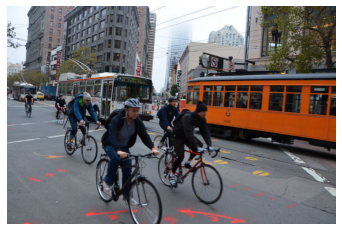

In [10]:
url ="https://farm8.staticflickr.com/7301/8862358875_eecba9fb10_z.jpg"
preproc_img,normalized_inp = prepare_data(url)
plt.imshow(preproc_img.permute(1,2,0)); plt.axis('off'); plt.show()

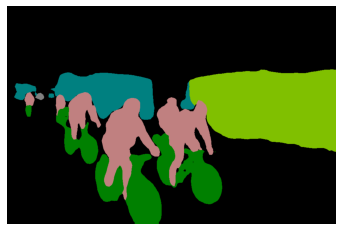

In [11]:
#Visualize segmentation output using utility method.
out_max =show_segmentation(normalized_inp)

In [12]:
"""
The below wrapper computes the segmentation model output and sums the pixel scores for
all pixels predicted as each class, returning a tensor with a single value for
each class. This makes it easier to attribute with respect to a single output
scalar, as opposed to an individual pixel output attribution.
"""
def agg_segmentation_wrapper(inp):
    model_out = fcn(inp)['out']
    # Creates binary matrix with 1 for original argmax class for each pixel
    # and 0 otherwise. Note that this may change when the input is ablated
    # so we use the original argmax predicted above, out_max.
    selected_inds = torch.zeros_like(model_out[0:1]).scatter_(1, out_max, 1)
    agg_seg_wrap=(model_out * selected_inds).sum(dim=(2,3))
    return agg_seg_wrap

In [13]:
#This utility function shows predicted classes by model model in the input image
def predictions(normalized_inp):
    preds = agg_segmentation_wrapper(normalized_inp)
    pred_label_idx= torch.nonzero(preds, as_tuple=True)[1]
    predictions =[classes[(idx.item())] for idx in pred_label_idx[1:]]
    pre_dict ={"predictions":predictions}
    return pre_dict

In [14]:
fcn = get_model()
predictions(normalized_inp)

{'predictions': ['bicycle', 'bus', 'car', 'person', 'train']}

We see that the segmentation model has identified regions including person, bicicyle, train,bus and cars. We will now interpret the model using Captum to understand what pixels contribute to these predictions.

### Interpreting with Captum

We can now construct a LayerGradCAM attribution object using the above wrapper, as well as the desired convolution layer for attribution. Generally, the final convolution layer is used for GradCAM attribution. Let do it for target class 6(Bus)

In [15]:
def lgc_attributions(normalized_inp):
    lgc = LayerGradCam(agg_segmentation_wrapper, fcn.backbone.layer4[2].conv3)
    gc_attr = lgc.attribute(normalized_inp, target=6)
    la = LayerActivation(agg_segmentation_wrapper, fcn.backbone.layer4[2].conv3)
    activation = la.attribute(normalized_inp)
    print("Input Shape:", normalized_inp.shape)
    print("Layer Activation Shape:", activation.shape)
    print("Layer GradCAM Shape:", gc_attr.shape)
    return gc_attr,activation

In [16]:
gc_attr, _ =lgc_attributions(normalized_inp)

Input Shape: torch.Size([1, 3, 640, 966])
Layer Activation Shape: torch.Size([1, 2048, 80, 121])
Layer GradCAM Shape: torch.Size([1, 1, 80, 121])


 We can now visualize the Layer GradCAM attributions using the Captum visualization utilities

In [18]:
def attributions_visualization(img_attr,title):
    fig, _ = viz.visualize_image_attr(img_attr[0].cpu().permute(1,2,0).detach().numpy(),sign="all",title=title)
    fig.savefig("data/"+title + ".png")


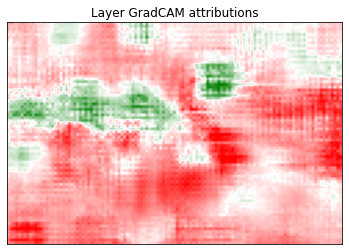

In [19]:
attributions_visualization(gc_attr,title="Layer GradCAM attributions")

We can understand this better by overlaying it on the original image. In order to do this, we need to upsample the layer GradCAM attributions to match the input size.

In [20]:
upsampled_gc_attr = LayerAttribution.interpolate(gc_attr,normalized_inp.shape[2:])
print("Upsampled Shape:",upsampled_gc_attr.shape)

Upsampled Shape: torch.Size([1, 1, 640, 966])


In [21]:
#lets define a vis function for overlayed output
def attributions_visualization_multiple(img_attr,normalized_inp,):
    upsampled_img_attr = LayerAttribution.interpolate(img_attr,normalized_inp.shape[2:])
    print("Upsampled Shape:",upsampled_img_attr.shape)
    fig, _ =viz.visualize_image_attr_multiple(upsampled_img_attr[0].cpu().permute(1,2,0).detach().numpy(),
        original_image=preproc_img.permute(1,2,0).numpy(),
        signs=["all", "positive", "negative"],methods=["original_image", "blended_heat_map","blended_heat_map"],
                                      titles=["Original Image", "Positive GradCAM ", "Negative GradCAM"])
    fig.savefig("data/LayerGradCam_overlayed.png")

Upsampled Shape: torch.Size([1, 1, 640, 966])


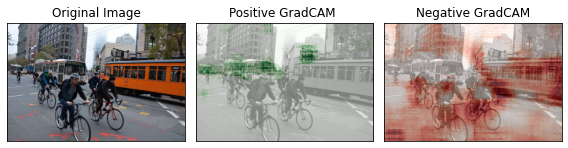

In [22]:
attributions_visualization_multiple(gc_attr,normalized_inp)

We can now attribute using a perturbation-based method, Feature Ablation to interpret the model in a different way.

In [23]:
def ablate_features(normalized_inp):
    fa = FeatureAblation(agg_segmentation_wrapper)
    fa_attr = fa.attribute(normalized_inp, feature_mask=out_max, perturbations_per_eval=2, target=6)
    fa_attr_without_max = (1 - (out_max == 6).float())[0] * fa_attr
    print("Feature Ablation Shape:", fa_attr.shape)
    print("Feature Ablation wo max Shape:", fa_attr_without_max.shape)
    return fa_attr,fa_attr_without_max

In [24]:
fa_attr,fa_attr_without_max =ablate_features(normalized_inp)


Feature Ablation Shape: torch.Size([1, 3, 640, 966])
Feature Ablation wo max Shape: torch.Size([1, 3, 640, 966])


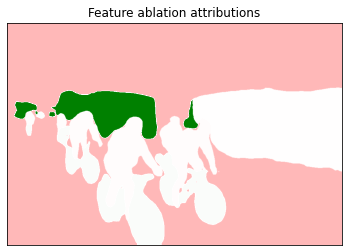

In [25]:
attributions_visualization(fa_attr, title="Feature ablation attributions")

Clearly, the bus region is most salient as expected, since that is the target we are interpreting. To better visualize the relative importance of the remaining regions, we can set the attributions of the bus area to 0 and visualize the remaining area.

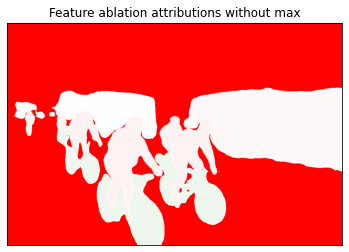

In [26]:
attributions_visualization(fa_attr_without_max,title="Feature ablation attributions without max")

Between the remaining regions, it seems that the background and humansand train contribute positively to the bus prediction.Ablating the bicycle appears to have no effect on the bus prediction.

###### Captum Insights